In [169]:
import tensorflow as tf
from keras.src.layers import Bidirectional
from tensorflow.keras import mixed_precision
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
mixed_precision.set_global_policy('mixed_float16')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('data/imdb_dataset.csv')


Num GPUs Available:  1


In [170]:
import numpy as np

# --- 1. Define GloVe parameters ---
# This path must point to your downloaded file
GLOVE_FILE = 'data/glove.6B.100d.txt'
EMBEDDING_DIM = 100  # This MUST match the file name (100d)

# --- 2. Load GloVe vectors into a dictionary ---
embeddings_index = {}
print(f"Loading GloVe vectors from {GLOVE_FILE}...")

try:
    with open(GLOVE_FILE, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
except FileNotFoundError:
    print(f"\n*** ERROR: GloVe file not found. ***")
    print(f"Please download '{GLOVE_FILE}' and place it in your project folder.")

print(f"Successfully loaded {len(embeddings_index)} word vectors.")

Loading GloVe vectors from data/glove.6B.100d.txt...
Successfully loaded 400000 word vectors.


Split the original DataFrame into train and test sets
80% for training, 20% for testing.

In [171]:
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

print(f"Full dataset size: {len(dataset)}")
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
train_df.head(10)

Full dataset size: 50000
Training set size: 40000
Test set size: 10000


,review,sentiment
39087,That's what I kept asking myself during the ma...,negative
30893,I did not watch the entire movie. I could not ...,negative
45278,A touching love story reminiscent of In the M...,positive
16398,This latter-day Fulci schlocker is a totally a...,negative
13653,"First of all, I firmly believe that Norwegian ...",negative
13748,I don't know how this movie received so many p...,negative
23965,Nightmare Weekend stars a cast of ridiculous a...,negative
45552,":::SPOILER ALERT:::<br /><br />Soooo, Arnie's ...",negative
30219,The people who are bad-mouthing this film are ...,positive
24079,"<br /><br />As usual, I was really looking for...",negative


Defining dataset parameters

In [172]:
VOCAB_SIZE = 5000
MAX_LEN = 300

Tokenization

In [173]:
# Create the 0/1 labels
y_train = train_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
y_test = test_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

# Process Reviews (X data)
tokenizer = Tokenizer(num_words=VOCAB_SIZE)

# IMPORTANT: Fit the tokenizer ONLY on the training text
tokenizer.fit_on_texts(train_df['review'])

# Now, transform both train and test text
X_train = tokenizer.texts_to_sequences(train_df['review'])
X_test = tokenizer.texts_to_sequences(test_df['review'])

# Pad the sequences
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)

print("\n--- First 10 rows of processed X_train (numbers) ---")
print(X_train[:10])
np.set_printoptions(threshold=np.inf)
print("\n--- Full 1st row of processed X_train ---")
print(X_train[0])
np.set_printoptions(threshold=0)


--- First 10 rows of processed X_train (numbers) ---
[[  81 3155  195 ...  205  351 3856]
 [   0    0    0 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [   0    0    0 ...  661  335  155]
 [   0    0    0 ...   17   63    6]
 [  12  107   97 ...  483    7    7]]

--- Full 1st row of processed X_train ---
[  81 3155  195   20  239    2    1  447    7    7   10  205 4982  144
   21   63   27   15   74  365  302    3   19   18    9  205   26  307
   12   14    1  115  439    2   14    1 1704  615   70  424  381   10
   89  118   48  112  370   33   35   18   43   10   13   92  485   15
    3  364 1182   61    8    1  470  216 1014    5 4160    8    3  174
    4   34  440  697  623   12 3748  237  111  848   35  170   30  219
  197    1  428  367   55 3765    3  278    7    7  157 1707  187    6
    1  727 1935    1 1200    4 2946 3749 1828    2  147  144    3  228
    4    3  207  323    2  144 1083   16   88    4  132 2871   18   10
  153   99    4    1 4020  302   11 

In [174]:
# --- 1. Get your tokenizer's vocabulary ---
# (Assumes 'tokenizer' is already fit)
VOCAB_SIZE_FINAL = tokenizer.num_words + 1
# --- 2. Create an empty matrix ---
embedding_matrix = np.zeros((VOCAB_SIZE_FINAL, EMBEDDING_DIM))
# --- 3. Fill the matrix ---
words_found = 0
print(f"Building embedding matrix for top {VOCAB_SIZE} words...")
for word, i in tokenizer.word_index.items():
    # --- 4. THIS IS THE CRITICAL FIX ---
    # Only check for words within our 5000-word limit
    # The tokenizer's word_index is 1-based.
    if i >= VOCAB_SIZE_FINAL:
        continue  # Skip this word, it's not in our top 5000

    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:
        # Word was found in GloVe, so add it to our matrix
        embedding_matrix[i] = embedding_vector
        words_found += 1

print(f"Done. Found {words_found} / {VOCAB_SIZE} words in GloVe.")

Building embedding matrix for top 5000 words...
Done. Found 4920 / 5000 words in GloVe.


Verifying train split 50/50

In [175]:
# dd = pd.Series(y_train).value_counts()
# sns.barplot(x=np.array(['negative','positive']),y=dd.values)
# plt.show()

Verifying test split 50/50

In [176]:
# dd = pd.Series(y_test).value_counts()
# sns.barplot(x=np.array(['negative','positive']),y=dd.values)
# plt.show()

Hyperparameters

In [177]:
EMBEDDING_DIM = 100
LSTM_UNITS = 100  # This controls the "power" or "memory" of your LSTM layer.
DROPOUT = 0.1  # helps prevent the model from "memorizing" the data.

Building model

In [178]:
from keras.src.callbacks import EarlyStopping
from keras.src import regularizers

# --- 1. Create the Model ---
model = Sequential()

# --- 2. Add the Embedding Layer ---
# This layer turns your number sequences (e.g., [0, 0, 5, 23])
# into meaningful vectors.
model.add(Embedding(
    input_dim=VOCAB_SIZE_FINAL,
    output_dim=EMBEDDING_DIM,  # Must be 100
    weights=[embedding_matrix],  # <-- This is the magic
    trainable=True,  # <-- Freeze the layer
    input_length=MAX_LEN  # (This is optional, but explicit)
))

# --- 3. Add the LSTM Layer ---
# This is the "brain" that reads the sequences.
# dropout=0.2 helps prevent the model from "memorizing" the data.
model.add(Bidirectional(LSTM(
    units=LSTM_UNITS,
    dropout=DROPOUT,
    return_sequences=True,
    # kernel_regularizer=regularizers.L2(0.001)
)))

model.add(LSTM(
    units=LSTM_UNITS,
    dropout=DROPOUT,
    # kernel_regularizer=regularizers.L2(0.001)
))

# --- 4. Add the Final Output Layer ---
# A single neuron with 'sigmoid' activation.
# Sigmoid is perfect for 0/1 (binary) classification.
# It will output a single number between 0 (negative) and 1 (positive).
model.add(Dense(units=1, activation='sigmoid'))

# --- 4. Set up EarlyStopping ---
early_stopper = EarlyStopping(monitor='val_accuracy',
                            patience=3, # Wait 3 epochs
                            restore_best_weights=True)

# --- 5. Print a summary of your model ---
print(model.summary())

/home/zminde/sentiment_project/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ ?                      │       500,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,100 (1.91 MB)

 Trainable params: 500,100 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

None


Compiling model

In [179]:
from tensorflow.keras.optimizers import Adam

# 'adam' is an efficient and popular optimizer.
# 'binary_crossentropy' is the correct loss function for a
# binary (0 vs 1) classification problem.
LEARNING_RATE = 0.00005
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\nModel compiled successfully.")


Model compiled successfully.


Training model

In [180]:
import time

# --- Set training parameters ---
BATCH_SIZE = 128  # How many reviews to process at a time
EPOCHS = 20  # How many times to loop over the entire training dataset

print("\nStarting training...")
# --- 2. Get the start time ---
start_time = time.time()

# --- Run the training! ---
history = model.fit(
    X_train, y_train,
    verbose=1,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[early_stopper]
)

# --- 3. Calculate and print the elapsed time ---
end_time = time.time()

elapsed_time = end_time - start_time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")
print(f"\nTraining complete.")
print("\nTraining complete.")


Starting training...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.6132 - loss: 0.6524 - val_accuracy: 0.7472 - val_loss: 0.5387
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.7071 - loss: 0.5712 - val_accuracy: 0.7856 - val_loss: 0.4766
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.7434 - loss: 0.5244 - val_accuracy: 0.8001 - val_loss: 0.4469
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.7651 - loss: 0.4913 - val_accuracy: 0.8098 - val_loss: 0.4298
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.7828 - loss: 0.4659 - val_accuracy: 0.8209 - val_loss: 0.4141
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.7944 - loss: 0.4465 - val_accuracy: 0.8330 - val_loss: 0.3835
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.8050 - loss: 0.4314 - val_accuracy: 0.8381 - val_loss: 0.3742
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.

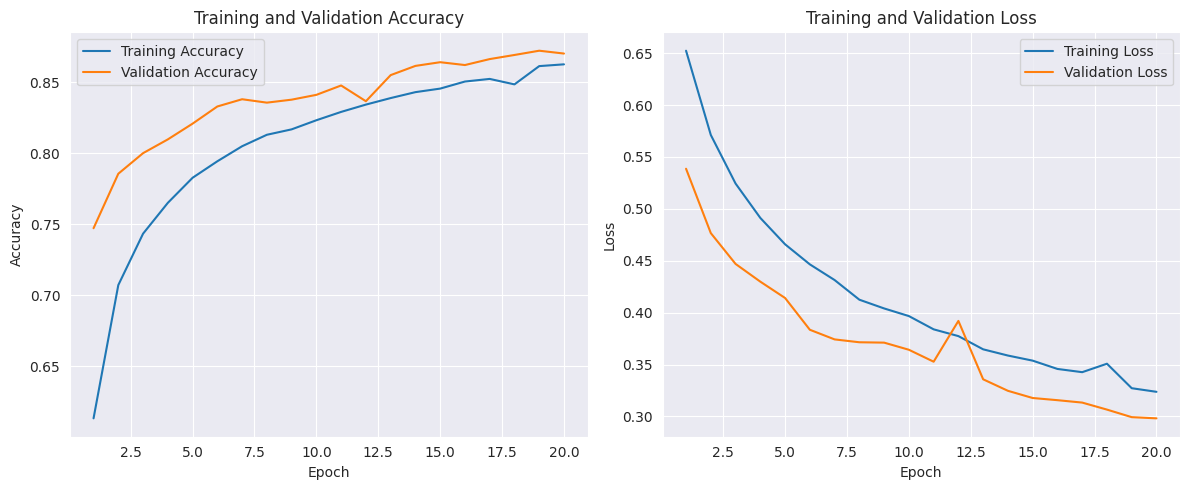

In [181]:
import matplotlib.pyplot as plt

# Your 'history' object has a 'history' dictionary
# Let's get the data from it
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs (which is 5 in your case)
epochs_range = range(1, len(train_acc) + 1)

# --- Create the plots ---
plt.figure(figsize=(12, 5))

# --- Plot 1: Training & Validation Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# --- Plot 2: Training & Validation Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Get final score

In [182]:
# This runs the model on your test data one last time
print("Evaluating model on test data...")
score, acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

print(f"\nFinal Test Loss: {score:.4f}")
print(f"Final Test Accuracy: {acc:.4f}")

Evaluating model on test data...
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8723 - loss: 0.2993

Final Test Loss: 0.2993
Final Test Accuracy: 0.8723


Validating

In [183]:
texts_to_predict = [
    "This was the best movie I have ever seen!",
    "I really hated this film. It was slow and boring.",
    "The acting was decent, but the plot was a little weak.",
    "Scariest movie I have ever seen and",
]


def get_sentiment_prediction(text):
    # 1. Tokenize
    sequence = tokenizer.texts_to_sequences([text])

    # 2. Pad
    padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN)

    # 3. Predict
    prediction = model.predict(padded_sequence, verbose=0)

    # 4. Get score and label
    score = prediction[0][0]
    label = "Positive" if score > 0.5 else "Negative"

    # 5. Return the data instead of printing
    return score, label


import textwrap
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# (Make sure your get_sentiment_prediction function is defined above)
# def get_sentiment_prediction(text): ...

# --- 2. Set your fixed text width ---
text_width = 40

print("Predicting...\n")
print("=" * (text_width + 4))  # Print a header line

# --- 3. Loop, predict, and print as formatted blocks ---
for text in texts_to_predict:
    # Get the prediction from your function
    score, sentiment = get_sentiment_prediction(text)

    # Use textwrap.fill() to add the \n characters
    wrapped_text = textwrap.fill(text, width=text_width)

    # Print the wrapped review text
    print(wrapped_text)

    # Print the result on a new, indented line
    print(f"\n  -> Prediction: {score:.4f} ({sentiment})")
    print("=" * (text_width + 4))  # Print a separator

Predicting...

This was the best movie I have ever
seen!

  -> Prediction: 0.8750 (Positive)
I really hated this film. It was slow
and boring.

  -> Prediction: 0.0274 (Negative)
The acting was decent, but the plot was
a little weak.

  -> Prediction: 0.0308 (Negative)
Scariest movie I have ever seen and

  -> Prediction: 0.7349 (Positive)
